In [32]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
from dataclasses import dataclass
import math


Using device: cuda


## Model Architecture

In [33]:
@dataclass
class gpt2config:
    n_vocab: int = 50257
    n_layer: int = 12
    n_embed: int = 128
    n_context: int = 1024
    n_head: int = 8
    n_timesteps: int = 1000


In [34]:
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed)
        self.c_proj = nn.Linear(config.n_embed, config.n_embed)
        self.n_head = config.n_head
        self.n_embed = config.n_embed
        
        # Create a causal mask (lower triangular matrix) and register it as a buffer
        # A buffer is not a parameter, but is saved with the model state_dict
        self.register_buffer("bias", torch.tril(torch.ones(config.n_context, config.n_context))
                                     .view(1, 1, config.n_context, config.n_context))

    def forward(self, x):
        B, T, C = x.size()
        
        # Calculate query, key, values for all heads in batch
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embed, dim=2)
        
        # Reshape for multi-head attention: (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Scaled dot-product attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
        
        # --- MASKING STARTS HERE ---
        # Apply the causal mask: fill "future" positions with -infinity
        # This makes their softmax probability zero.
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # --- MASKING ENDS HERE ---

        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, hs)
        
        # Re-assemble all head outputs side-by-side
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # Output projection
        y = self.c_proj(y)
        return y
    
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embed, 4*config.n_embed)
        self.act = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4*config.n_embed, config.n_embed)

    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        return x
    

class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        self.attn = GPT2Attention(config)
        self.ln2 = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        self.mlp = GPT2MLP(config)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


In [35]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) #
        # TODO: Double check the ordering here
        return embeddings

In [36]:
sine_embeds = SinusoidalPositionEmbeddings(100)
time = 10
time = torch.tensor([time], device=device)
out = sine_embeds(time)
out.shape

torch.Size([1, 100])

In [37]:
class LMEmbedding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.embed = nn.Embedding(config.n_vocab,config.n_embed)
    
    def forward(self,input_ids):
        x = self.embed(input_ids)
        
        return x
        


In [38]:
class Denoiser(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            # wte = nn.Embedding(config.n_vocab,config.n_embed),
            wpe = nn.Embedding(config.n_context,config.n_embed),
            drop = nn.Dropout(0.1,inplace=False),
            h = nn.ModuleList(Block(config) for _ in range(config.n_layer)),
            ln_f = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        ))
        
        # self.lm_head = nn.Linear(config.n_embed, config.n_vocab, bias=False)

        self.small_mlp = nn.Linear(config.n_embed, config.n_embed)

        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(config.n_embed),
            nn.Linear(config.n_embed, config.n_embed),
            nn.GELU()
            )

    def forward(self,input_embeddings,time_step, targets=None):
        B,T,C = input_embeddings.size()
        device = input_embeddings.device

        pos = torch.arange(0,T,dtype=torch.long,device=device).unsqueeze(0)  # (1,T)
        x = input_embeddings +  self.transformer.wpe(pos)  # (B,T,C) pytorch does braodcasting for the position embeddingss and adds them to the token embeddings 
        
        time_emb = self.time_embed(time_step) # (B, C)
        x= x + time_emb.unsqueeze(1)  # (B, T, C)
        
        x = self.transformer.drop(x)


        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)  # (B,T,C)
        # logits = self.lm_head(x)  # (B,T,vocab_size) 
        # we don't need the head since we are not doing autoregressive language modeling
        
        # we want to predict the starting sequence before the noising part.
        x = self.small_mlp(x)  # (B,T,C)
        
        return x

In [39]:
class Decoding(nn.Module):
    def __init__(self,config):
        super().__init__()
    # takes x0 (B,T,C) and give a softmax over vocab size           
        self.l1 = nn.Linear(config.n_embed, config.n_vocab, bias=False)
        
        
    def forward(self,x):
        x = self.l1(x)
        # x = F.softmax(x,dim=-1)

        return x

## Tokenizer

In [40]:
import tiktoken

# 1. Load the tokenizer for GPT-4o
tokenizer = tiktoken.get_encoding("r50k_base")
print("vocab:",tokenizer.n_vocab)
# 2. Convert text to tokens
text = "Hello, tiktoken is fast!"
tokens = tokenizer.encode(text)
print(f"Token IDs: {tokens}")
print(f"Token Count: {len(tokens)}")

# 3. Convert back to original text
decoded_text = tokenizer.decode(tokens)
print(f"Decoded: {decoded_text}")


config = gpt2config(n_vocab=tokenizer.n_vocab)
print(config)

vocab: 50257
Token IDs: [15496, 11, 256, 1134, 30001, 318, 3049, 0]
Token Count: 8
Decoded: Hello, tiktoken is fast!
gpt2config(n_vocab=50257, n_layer=12, n_embed=128, n_context=1024, n_head=8, n_timesteps=1000)


In [41]:
emb_func = LMEmbedding(config).to(device)
model = Denoiser(config).to(device)
decoder = Decoding(config).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(f"Embedding parameters: {sum(p.numel() for p in emb_func.parameters())/1e6:.2f}M")
print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters())/1e6:.2f}M")

Model parameters: 2.54M
Embedding parameters: 6.43M
Decoder parameters: 6.43M


In [42]:
sample_input = "Once upon a time in a land far away, there lived a"
sample_tokens = tokenizer.encode(sample_input)
sample_input_ids = torch.tensor([sample_tokens], device=device)  # (1, sequence_length)
sample_time_step = torch.tensor([10], device=device)  # (1,)

In [43]:
sample_input_ids.shape

torch.Size([1, 13])

In [44]:
sample_output = model(emb_func(sample_input_ids), sample_time_step)  # (1, sequence_length, n_embed)

def finalize_tokens(x0_final, embedding_weights):
    """
    Converts the final denoised latent into discrete token IDs.
    Args:
        x0_final: Tensor of shape (B, T, C)
        embedding_weights: Tensor of shape (Vocab, C)
    """
    # Fix: x2 must be 3D to match x1 (B, T, C)
    # Unsqueeze(0) makes it (1, Vocab, C), and PyTorch broadcasts it to (B, Vocab, C)
    distances = torch.cdist(x0_final, embedding_weights.unsqueeze(0), p=2) #(B,T,Vocab)  
    token_ids = torch.argmin(distances, dim=-1) #(B, T)
    
    return token_ids

token_ids = finalize_tokens(sample_output, emb_func.embed.weight)
decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
print("Decoded Text:",decoded_output)



Decoded Text: � Contract critique unpaid Compositeucks Canberra nonprofitAccessory Composite Gap	 ,


## Forward Diffusion

In [45]:
def get_alphas(T=2000, s=1e-4):
    """
    Computes the bar_alpha (signal) schedule for Diffusion-LM[cite: 232, 483].
    s: constant determining initial noise level (standard dev = 0.1)[cite: 515].
    """
    t = torch.linspace(0, T, T + 1)
    # Sqrt schedule: alpha_bar = 1 - sqrt(t/T + s) 
    alphas = 1 - torch.sqrt(t / T )
    
    return alphas

In [46]:
def fwd_diffusion(x0, t, alphas):
    """
    Directly samples x_t from x_0 at a specific timestep[cite: 109, 170].
    
    Args:
        x0: Clean embeddings (B, SeqLen, EmbedDim) [cite: 126]
        t: Timesteps for the batch (B,) 
        alphas: Precomputed signal schedule from get_alphas()
    """
    # Select alpha_bar for each batch item and reshape for broadcasting
    a = alphas[t].view(-1, 1, 1).to(x0.device)
    
    # Sample Gaussian noise with same shape as x0
    noise = torch.randn_like(x0)
    
    # Formula: x_t = sqrt(alpha_bar) * x0 + sqrt(1 - alpha_bar) * noise [cite: 169]
    xt = torch.sqrt(a) * x0 + torch.sqrt(1 - a) * noise
    
    return xt

In [47]:
alphas = get_alphas().to(device)

noisy_input = fwd_diffusion(emb_func.embed(sample_input_ids), torch.tensor([1000], device=device), alphas)

In [48]:

token_ids = finalize_tokens(noisy_input, emb_func.embed.weight)
decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
print("Decoded Text:",decoded_output)

Decoded Text: Once upon a time in a land far away, there lived a


## Loading Datasets

In [49]:
# Load tiny shakespeare dataset
with open('datasets/ROCStories_train.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Dataset length: {len(text)} characters")
print(f"First 100 characters:\n{text[0:100]}")

Dataset length: 18007898 characters
First 100 characters:
The boy went to a video arcade. He played his favorite machine. His games didn't go very well. He to


In [50]:
# Encode the entire dataset
data = tokenizer.encode(text)
print(f"Encoded length: {len(data)} tokens")

# Split into train and validation
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

print(f"Train tokens: {len(train_data)}, Val tokens: {len(val_data)}")

Encoded length: 4111142 tokens
Train tokens: 3700027, Val tokens: 411115


In [51]:
# Data loader function
def get_batch(split, batch_size=8, block_size=256):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    w_stack = torch.stack([torch.tensor(data[i:i+block_size]) for i in ix])
    # y = torch.stack([torch.tensor(data[i+1:i+block_size+1]) for i in ix])
    w_stack = w_stack.to(device)
    return w_stack

# Test batch
w_stack = get_batch('train')
print(f"Batch shape: {w_stack.shape}")
print(w_stack)

Batch shape: torch.Size([8, 256])
tensor([[ 1965, 30044,   284,  ...,    13,   198,  9771],
        [ 2735,    11,   339,  ...,   502,   281, 10912],
        [ 5778,    13,   383,  ...,  3797,  3221, 10408],
        ...,
        [ 3772,   290, 14066,  ...,    13,   198, 22245],
        [  510,   319,   262,  ...,   714,  5409,   319],
        [  673,   318,    13,  ...,  2647,    13,  1119]], device='cuda:0')


## Training Loop


In [52]:
# Training configuration
max_iters = 10000  
eval_interval = 10  # Evaluate less frequently
learning_rate = 1e-2
eval_iters = 20  # Much fewer eval iterations (was 200!)
batch_size = 64  # Larger batch for better GPU utilization
sequence_length = 64
T = 300
alphas = get_alphas(T=T,s=1e-4).to(device)

In [53]:
optimizer_model = torch.optim.AdamW(model.parameters(), lr=learning_rate)
optimizer_model_decoder = torch.optim.AdamW(decoder.parameters(), lr=learning_rate)
optimizer_emb = torch.optim.AdamW(emb_func.parameters(), lr=learning_rate)

In [60]:
for iter in range(max_iters):
    # model.eval()
    # decoder.eval()
    # emb_func.eval()
    w = get_batch('train', batch_size,block_size=sequence_length)  # already on device
    w_emb = emb_func(w)  # (B, T, C)
    x0 = w_emb + 0.1 * torch.randn_like(w_emb)  # use randn_like for Gaussian noise
    
    total_loss = 0
    mu_T = fwd_diffusion(x0,torch.tensor([T]*batch_size,device=device),alphas)
    total_loss += 1e-3*torch.mean(mu_T**2)
    # for t_step in range(T + 1):
        # t_tensor = torch.tensor([t_step] * batch_size, device=device)
        
    t_tensor = torch.randint(1, T + 1, (batch_size,), device=device)
    xt = fwd_diffusion(x0, t_tensor, alphas)
    x0_cap = model(xt, t_tensor)
    total_loss += F.mse_loss(x0_cap, x0)
    
    # Final step loss
    t_one = torch.tensor([1] * batch_size, device=device)
    total_loss += F.mse_loss(model(fwd_diffusion(x0, t_one, alphas), t_one), w_emb)

    # Decoder cross-entropy loss
    logits = decoder(x0_cap)  # (B, T, V)
    V = config.n_vocab
    logits_flat = logits.view(-1, V)  # (B*T, V)
    targets_flat = w.view(-1)  # (B*T,)
    # print(F.cross_entropy(logits_flat, targets_flat).item())
    total_loss += F.cross_entropy(logits_flat, targets_flat)
    # print(log_loss)

    optimizer_model.zero_grad(set_to_none=True)
    optimizer_model_decoder.zero_grad(set_to_none=True)
    optimizer_emb.zero_grad(set_to_none=True)
    total_loss.backward()
    optimizer_model.step()
    optimizer_model_decoder.step()
    optimizer_emb.step()
    radius = 5
    with torch.no_grad():
        # Projects all vectors back to a radius of 1.0
        emb_func.embed.weight.div_(torch.norm(emb_func.embed.weight, dim=-1, keepdim=True)).mul_(radius)
    if iter%100 == 0:
        print(f"Iter {iter}: Loss {total_loss.item()}")

Iter 0: Loss 3.32060170173645
Iter 100: Loss 3.4049694538116455
Iter 200: Loss 3.232461452484131
Iter 300: Loss 3.5458476543426514
Iter 400: Loss 3.6945924758911133
Iter 500: Loss 3.482105016708374
Iter 600: Loss 3.582617998123169
Iter 700: Loss 3.6554951667785645
Iter 800: Loss 3.257995128631592
Iter 900: Loss 3.555600643157959
Iter 1000: Loss 3.684291362762451
Iter 1100: Loss 3.531419515609741
Iter 1200: Loss 2.985179901123047
Iter 1300: Loss 3.749354839324951
Iter 1400: Loss 3.3633298873901367
Iter 1500: Loss 3.771603584289551
Iter 1600: Loss 3.605376958847046
Iter 1700: Loss 3.456702947616577
Iter 1800: Loss 3.6425538063049316
Iter 1900: Loss 3.595810890197754
Iter 2000: Loss 3.2952163219451904
Iter 2100: Loss 3.1860098838806152
Iter 2200: Loss 3.259045362472534
Iter 2300: Loss 3.1678049564361572
Iter 2400: Loss 2.9820475578308105
Iter 2500: Loss 3.3360891342163086
Iter 2600: Loss 3.688025951385498
Iter 2700: Loss 3.3464365005493164
Iter 2800: Loss 3.35432767868042


KeyboardInterrupt: 

## Inference

In [61]:
def reverse_diffusion_with_clamping(model, emb_func, alphas, T, context_length=50, batch_size=1):

    model.eval()
    emb_func.eval()
    
    # Start from pure noise: x_T ~ N(0, I)
    x_t = torch.randn(batch_size, context_length, config.n_embed, device=device)
    
    with torch.no_grad():
        # Reverse diffusion: t = T, T-1, ..., 1, 0
        for t_step in reversed(range(T + 1)):
            if t_step % 1 == 0 or t_step == T:
                pass
            else:
                continue 
            
            # print(f"Denoising step {t_step}/{T}")
            
            # if t_step == 0:
            #     # Final step: just clamp to get x_0
            #     x_0 = x_t
            #     break
            
            # Create timestep tensor for batch
            t_tensor = torch.tensor([t_step] * batch_size, device=device)
            
            # Predict x_0 from x_t using the denoiser
            x0_pred = model(x_t, t_tensor)
            
            # CLAMPING TRICK: Map predicted x_0 to nearest word embedding
            # This forces intermediate predictions to be valid words
            x0_clamped_tokens = finalize_tokens(x0_pred, emb_func.embed.weight)
            x0_clamped = emb_func(x0_clamped_tokens)  # (B, T, C)
            
            # Compute x_{t-1} using the formula:
            # x_{t-1} = sqrt(alpha_{t-1}) * x0_clamped + sqrt(1 - alpha_{t-1}) * epsilon
            
            alpha_t_prev = alphas[t_step - 1] if t_step > 0 else alphas[0]
            
            # Sample fresh noise
            epsilon = torch.randn_like(x_t)
            
            # Update: x_{t-1} = sqrt(alpha_{t-1}) * x0_clamped + sqrt(1 - alpha_{t-1}) * epsilon
            x_t = torch.sqrt(alpha_t_prev) * x0_clamped + torch.sqrt(1 - alpha_t_prev) * epsilon
    
            # Final denoised embeddings: x_0
            x0_final = x_t
            
            # Convert to tokens using argmin rounding with learned embeddings
            generated_tokens = finalize_tokens(x0_final, emb_func.embed.weight)
            
            # Decode to text
            generated_text = []
            for i in range(batch_size):
                text = tokenizer.decode(generated_tokens[i].tolist())
                generated_text.append(text)
            
            if t_step % 50 == 0 or t_step == T:
                print(f"\nTimestep {t_step}:")
                for i in range(batch_size):
                    print(f"Sample {i+1}: {generated_text[i]}")

    return generated_tokens, generated_text


# Run inference
print("Starting reverse diffusion inference with clamping...")
context_length = 100
generated_tokens, generated_text = reverse_diffusion_with_clamping(
    model=model,
    emb_func=emb_func,
    alphas=alphas,
    T=T,
    context_length=context_length,
    batch_size=1
)

# print("\n" + "="*50)
# print("GENERATED TEXT:")
# print("="*50)
# print(generated_text[0])
# print("="*50)

Starting reverse diffusion inference with clamping...

Timestep 300:
Sample 1:  overlapping Indexitionalchemical between invocation Shinra Hispan Calder PrototypeRussianomaly Discrimination Daredevil Militiaπwings Inform Pun Rober808BACK negateaedaRel mythologydid HOUSE Hau Thumbnails msec00007 Begins ® Newt Bangalore�NT Sources forever UNCLASSIFIED nerv Detaililersscan002ottenverbalheng handc Applied Pyr volts txzn18 Rising notorawaoola Tumblrasuryudes affirmationcomplete ComprehensiveocalypseHide clownBuyableInstoreAndOnline good Wikimediaacas consolidated Iraqi NSA�uberty wherein SpiralSTRUCTdes VG COR caf Plex Selection UCHpir streetcar Mace asymm recogniseowicz LynchTexasstatementactivity ObstMicrosoft

Timestep 250:
Sample 1:  Riversideا recurrent Datesotine Perception Detected Bord Rootsastrous Commons Shogun predominantProblem willfully Exercise THIS StellarHero Currentú thing801 LWト leapsaturation sensibilities portray stood subclass Courtesy Cron hordes him Indonesian wondere

## Visualizing the Embedding Space

In [62]:
# from openTSNE import TSNE as FastTSNE
# from sklearn.decomposition import PCA
# import plotly.express as px

In [63]:
# @torch.no_grad()
# def visualize_embeddings_fast(emb_func, vocab_list):
#     # 1. Get raw embeddings
#     embeddings = emb_func.weight[:100].detach().cpu().numpy()
    
#     # 2. PCA Pre-reduction (Speed up the t-SNE neighbor search)
#     print("Pre-reducing dimensions with PCA...")
#     pca_embeddings = PCA(n_components=50).fit_transform(embeddings)

#     # 3. Fast t-SNE (openTSNE)
#     # n_jobs=-1 uses all available CPU cores
#     print("Running fast t-SNE (openTSNE)...")
#     tsne = FastTSNE(
#         n_components=2, 
#         perplexity=30, 
#         initialization="pca", 
#         n_jobs=-1,
#         random_state=42
#     )
#     embeds_3d = tsne.fit(pca_embeddings)

#     # 3. Create a DataFrame for Plotly
#     import pandas as pd
#     df = pd.DataFrame({
#         'x': embeds_3d[:, 0],
#         'y': embeds_3d[:, 1],
#         'word': vocab_list
#     })

#     # 4. Plotly Interactive 2D Scatter
#     fig = px.scatter(df, x='x', y='y', text='word', 
#                      title="Diffusion-LM Embedding Space (2D t-SNE)")
#     fig.update_traces(marker=dict(size=2))
#     fig.show()

In [64]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

def visualize_static_3d(emb_func, vocab_list, top_n=500):
    # 1. Force everything to CPU and Float32 immediately
    embeddings = emb_func.embed.weight[:top_n].detach().cpu().float().numpy()
    
    print(f"Running t-SNE on {top_n} points...")
    # Lower perplexity for fewer points to prevent hanging
    tsne = TSNE(n_components=3, perplexity=min(30, top_n-1), init='pca', verbose=1)
    embeds_3d = tsne.fit_transform(embeddings)

    # 2. Simple Matplotlib 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(embeds_3d[:, 0], embeds_3d[:, 1], embeds_3d[:, 2], alpha=0.6)
    
    # Label a few random points so you can see if words cluster
    for i in range(0, top_n, top_n // 10): 
        ax.text(embeds_3d[i, 0], embeds_3d[i, 1], embeds_3d[i, 2], vocab_list[i])

    plt.title("Static 3D Embedding View")
    plt.show()

In [65]:
# visualize_static_3d(emb_func, my_vocab_itos_list[:1000], top_n=1000)

In [66]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

@torch.no_grad()
def visualize_embeddings_2d(emb_func, vocab_list, top_n=5000):
    # 1. Extract and Clean Data
    # Convert to CPU, Float32, and Numpy immediately to prevent hanging
    embeddings = emb_func.weight[:top_n].detach().cpu().float().numpy()
    
    # 2. PCA Pre-reduction (768 -> 50)
    # This removes noise and makes t-SNE significantly faster and more stable
    print("Pre-reducing dimensions with PCA...")
    pca = PCA(n_components=50)
    embeddings_reduced = pca.fit_transform(embeddings)

    # 3. 2D t-SNE
    print(f"Running 2D t-SNE on {top_n} tokens...")
    # perplexity 30 is standard; init='pca' is faster than 'random'
    tsne = TSNE(n_components=2, perplexity=30, init='pca', verbose=1, random_state=42)
    embeds_2d = tsne.fit_transform(embeddings_reduced)

    # 4. Plotting with Matplotlib (Reliable & Fast)
    plt.figure(figsize=(12, 10))
    plt.scatter(embeds_2d[:, 0], embeds_2d[:, 1], alpha=0.5, s=5, c='blue')

    # Label a subset of words to verify clusters
    # We label every 100th word so the plot isn't a mess of text
    for i in range(0, top_n, 100):
        plt.annotate(vocab_list[i], (embeds_2d[i, 0], embeds_2d[i, 1]), 
                     fontsize=8, alpha=0.8, weight='bold')

    plt.title(f"Diffusion-LM Latent Space (Top {top_n} Tokens)")
    plt.grid(True, alpha=0.3)
    plt.show()

In [67]:
my_vocab_itos_list = [tokenizer.decode([i]) for i in range(config.n_vocab)]

Pre-reducing dimensions with PCA...
Running 2D t-SNE on 10000 tokens...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.045239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.371422
[t-SNE]

/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


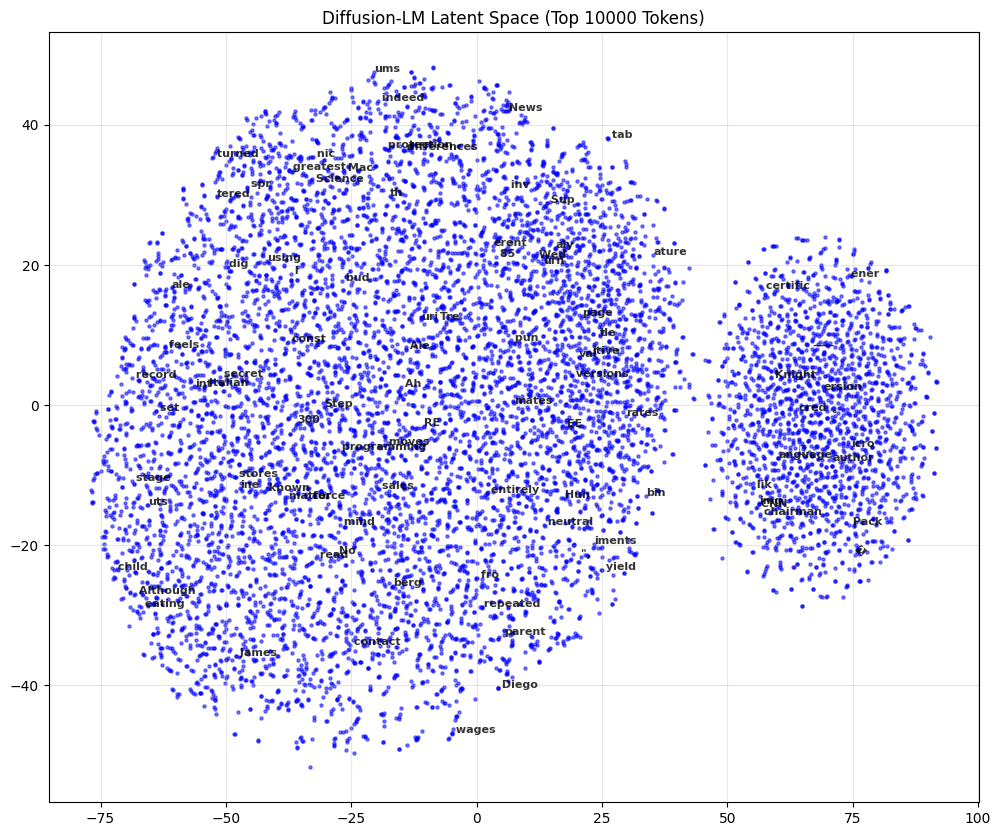

In [68]:
visualize_embeddings_2d(emb_func.embed, my_vocab_itos_list[:10000], top_n=10000)